<a href="https://colab.research.google.com/github/OjChi/DS-Lab/blob/main/Lab_3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experiment 3 - Naive Bayes Classifier

Objective:

(i) Apply Naive bayes classifier for given data see Naive_bayes_handout.zip file in edmodo.

(ii) Apply and compare Linear Discriminating Analysis with Naive bayes classifiers w.r.t. error, specificity and sensitivity

I have applied Naive Bayes Classifier for Text Classification of sms text.

Dataset:<br>
The dataset contains Spam and Ham messages. We have the text and its category. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pandas as pd
%matplotlib inline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Exploratory Data Analysis

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Engineering/BE/Sem8/DS/Lab/Lab3/Lab/SPAM text message 20170820 - Data.csv')

In [ ]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Our dataset has Message and Category columns which consist of object data type. There are 5572 messages. We have to check whether the category data is balanced or not.

####Q. How is the data divided between the classes?

In [ ]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
data['Category'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Category, dtype: float64

The Spam category has most words 86% of the entire dataset.

As we can see above, the dataset is unbalanced. We have to consider this when we build our model. As well as, we need to encode the labels to use our machine learning model. To achieve this we'll use the Label Encoder from scikit-learn

##Encoding

In [ ]:
le = LabelEncoder()

In [ ]:
data['Category_enc'] = le.fit_transform(data['Category'])

In [ ]:
data.head()

,Category,Message,Category_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
data.dtypes

Category        object
Message         object
Category_enc     int64
dtype: object

##Exploratory Data Analysis

##Data Prerpocessing

####Converting to lower and tokenizing

In [ ]:
tokenized_messages = data['Message'].str.lower().apply(word_tokenize)

print(tokenized_messages)

0       [go, until, jurong, point, ,, crazy.., availab...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [this, is, the, 2nd, time, we, have, tried, 2,...
5568      [will, ü, b, going, to, esplanade, fr, home, ?]
5569    [pity, ,, *, was, in, mood, for, that, ., so, ...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                  [rofl, ., its, true, to, its, name]
Name: Message, Length: 5572, dtype: object


####Removing non-alphanumeric characters

In [ ]:
def alpha(tokens):
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

0       [go, until, jurong, point, available, only, in...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, in, a, wkly, comp, to, win, fa, ...
3       [u, dun, say, so, early, hor, u, c, already, t...
4       [nah, i, do, not, think, he, goes, to, usf, he...
                              ...                        
5567    [this, is, the, time, we, have, tried, contact...
5568         [will, ü, b, going, to, esplanade, fr, home]
5569    [pity, was, in, mood, for, that, so, any, othe...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                     [rofl, its, true, to, its, name]
Name: Message, Length: 5572, dtype: object


####Removing stop words

In [ ]:
def remove_stop_words(tokens):
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

tokenized_messages = tokenized_messages.apply(remove_stop_words)

print(tokenized_messages)

0       [go, jurong, point, available, bugis, n, great...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, wkly, comp, win, fa, cup, final,...
3           [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, goes, usf, lives, around, though]
                              ...                        
5567    [time, tried, contact, u, pound, prize, claim,...
5568                   [ü, b, going, esplanade, fr, home]
5569                            [pity, mood, suggestions]
5570    [guy, bitching, acted, like, interested, buyin...
5571                                   [rofl, true, name]
Name: Message, Length: 5572, dtype: object


####Now performing Lemmatization

In [ ]:
def lemmatize(tokens):
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

tokenized_messages = tokenized_messages.apply(lemmatize)

print(tokenized_messages)

0       go jurong point available bugis n great world ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    time tried contact u pound prize claim easy ca...
5568                          ü b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object


In [ ]:
data['Message'] = tokenized_messages

data.head()

,Category,Message,Category_enc
0,ham,go jurong point available bugis n great world ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry wkly comp win fa cup final tkts may...,1
3,ham,u dun say early hor u c already say,0
4,ham,nah think go usf life around though,0


##Visualization

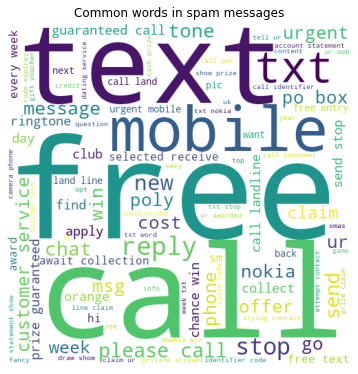

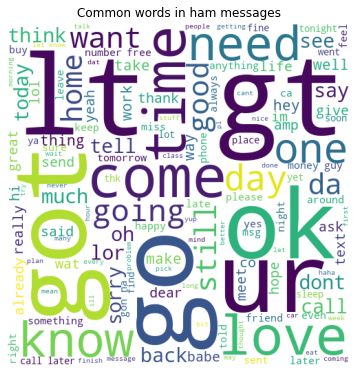

In [ ]:
spam = data[data['Category']=='spam']['Message'].str.cat(sep=', ')

ham = data[data['Category']=='ham']['Message'].str.cat(sep=', ')

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

spam_wc = wc.generate(spam)
            
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(spam_wc) 
plt.axis("off") 
plt.title("Common words in spam messages")
plt.tight_layout(pad = 0) 
plt.show() 
ham_wc = wc.generate(ham)
                   
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(ham_wc) 
plt.axis("off")
plt.title("Common words in ham messages")
plt.tight_layout(pad = 0) 
plt.show() 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


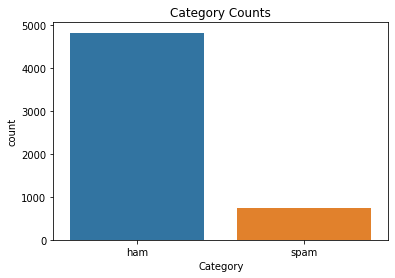

In [ ]:
sns.countplot(data['Category'])
plt.title("Category Counts")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Category
ham      7.664663
spam    12.566265
Name: word_count, dtype: float64


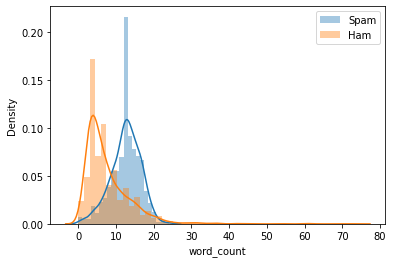

In [ ]:
data['word_count'] = data['Message'].str.split().str.len()

print(data.groupby('Category')['word_count'].mean())

sns.distplot(data[data['Category']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['Category']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

##Dividing Data

In [ ]:
X = data['Message']
y = data['Category_enc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

##Tokenizing data

In [ ]:
vectorizer = CountVectorizer(strip_accents='ascii')
train = vectorizer.fit_transform(X_train)
test = vectorizer.transform(X_test)

In [ ]:
len(train.toarray()),len(test.toarray())

(4457, 1115)

In [ ]:
X_train = pd.DataFrame(train.toarray(),columns=[i for i in range(len(train.toarray()[0]))])

In [ ]:
X_test = pd.DataFrame(test.toarray(),columns=[i for i in range(len(test.toarray()[0]))])

In [ ]:
nb = GaussianNB()

nb.fit(X_train, y_train)

print("Accuracy:",nb.score(X_test, y_test))

Accuracy: 0.8663677130044843


In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [ ]:
nb_lda = GaussianNB()

nb_lda.fit(X_train, y_train)

print("Accuracy:",nb_lda.score(X_test, y_test))

Accuracy: 0.8798206278026905


##Conclusion:
Inorder for NLP to work better tokenizing, lemmatization, removing non-alphanumeric are important. I also tried applying LDA to the data to see if it helps with the result. I was able to observe a difference of about 1% improvement.